# Анализ и результаты тестирования на IAM

In [1]:
import albumentations as A
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%cd /home/astrashnov/PaddleOCR/

/home/astrashnov/PaddleOCR


## Анализ датасетов

Посмотрим сначала на распределение символов в обучающем и тестовом датасетах:

In [2]:
def show_dir_info(input_dir):
    filenames = os.listdir(path=input_dir)
    dict_set = set()
    max_len = 0
    char_counter = Counter()
    for filename in filenames:
        label = filename.split('_')[0]
        dict_set = dict_set | set(label)
        max_len = max(max_len, len(label))
        char_counter = char_counter + Counter(label)
    dict_list = list(dict_set)
    print('Word number: {}'.format(len(filenames)))
    print('Max word length: ' + str(max_len))
    print('Alphabet size: ' + str(len(dict_list)))
    print('Dictionary: ' + ''.join(sorted(dict_list)))
    
    sorted_dict = sorted(dict(char_counter).items(), key=lambda kv: kv[1])
    keys = list(s[0] for s in sorted_dict)
    values = list(s[1] for s in sorted_dict)

    plt.figure(figsize=(12, 20))
    g = sns.barplot(y=keys, x=values)
    for i, value in enumerate(values):
        g.text(value, i, value, color='black', va='center')
    plt.title('Количество каждого символа в обучающем датасете')
    plt.xlabel('Количество в датасете')
    plt.ylabel('Символ')
    plt.show()

##### Обучающий датасет:

Word number: 60766
Max word length: 21
Alphabet size: 65
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


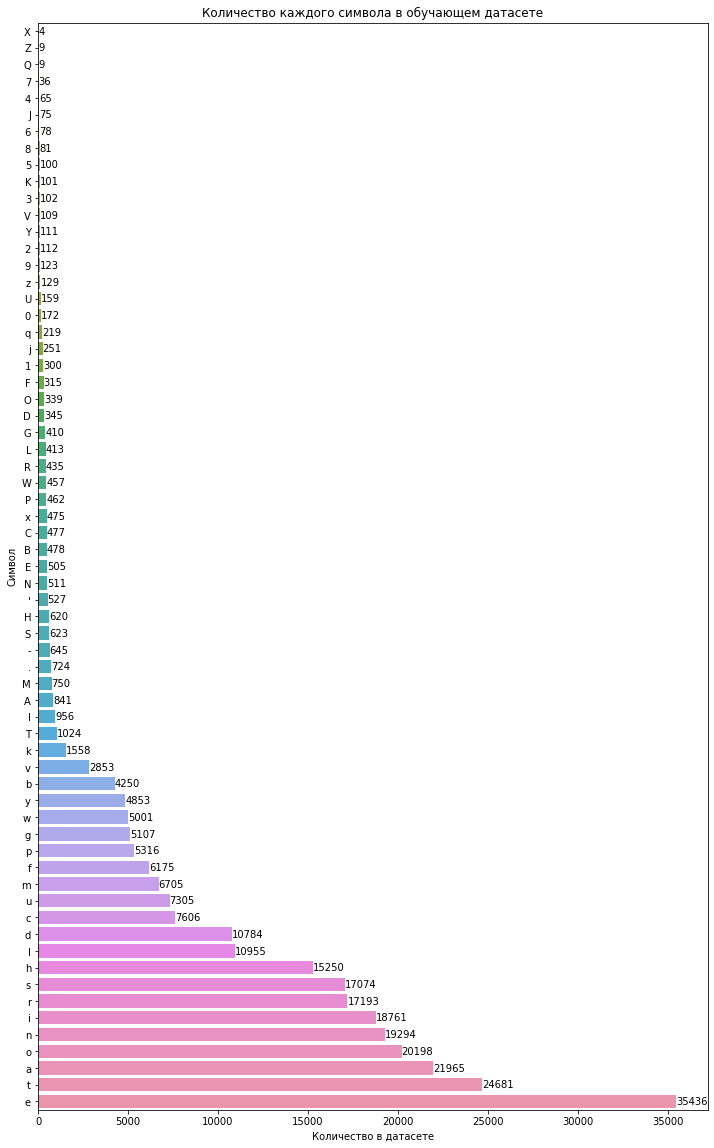

In [3]:
show_dir_info('/DATA/data/rec/iam_data/train_words')

##### Тестовый датасет:

Word number: 17755
Max word length: 21
Alphabet size: 63
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyz


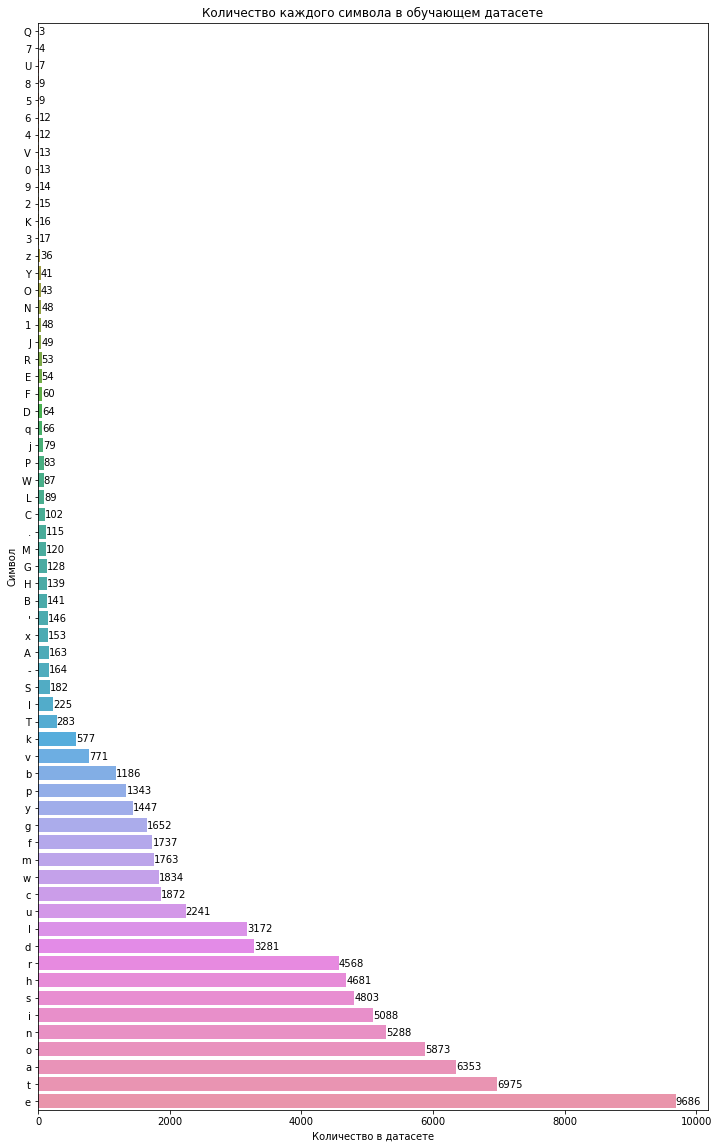

In [4]:
show_dir_info('/DATA/data/rec/iam_data/test_words')

Видно, что распределения символов в обучающем и тестовом датасетах похожи.

Посмотрим теперь на некотрые изображения из обучающего датасета:

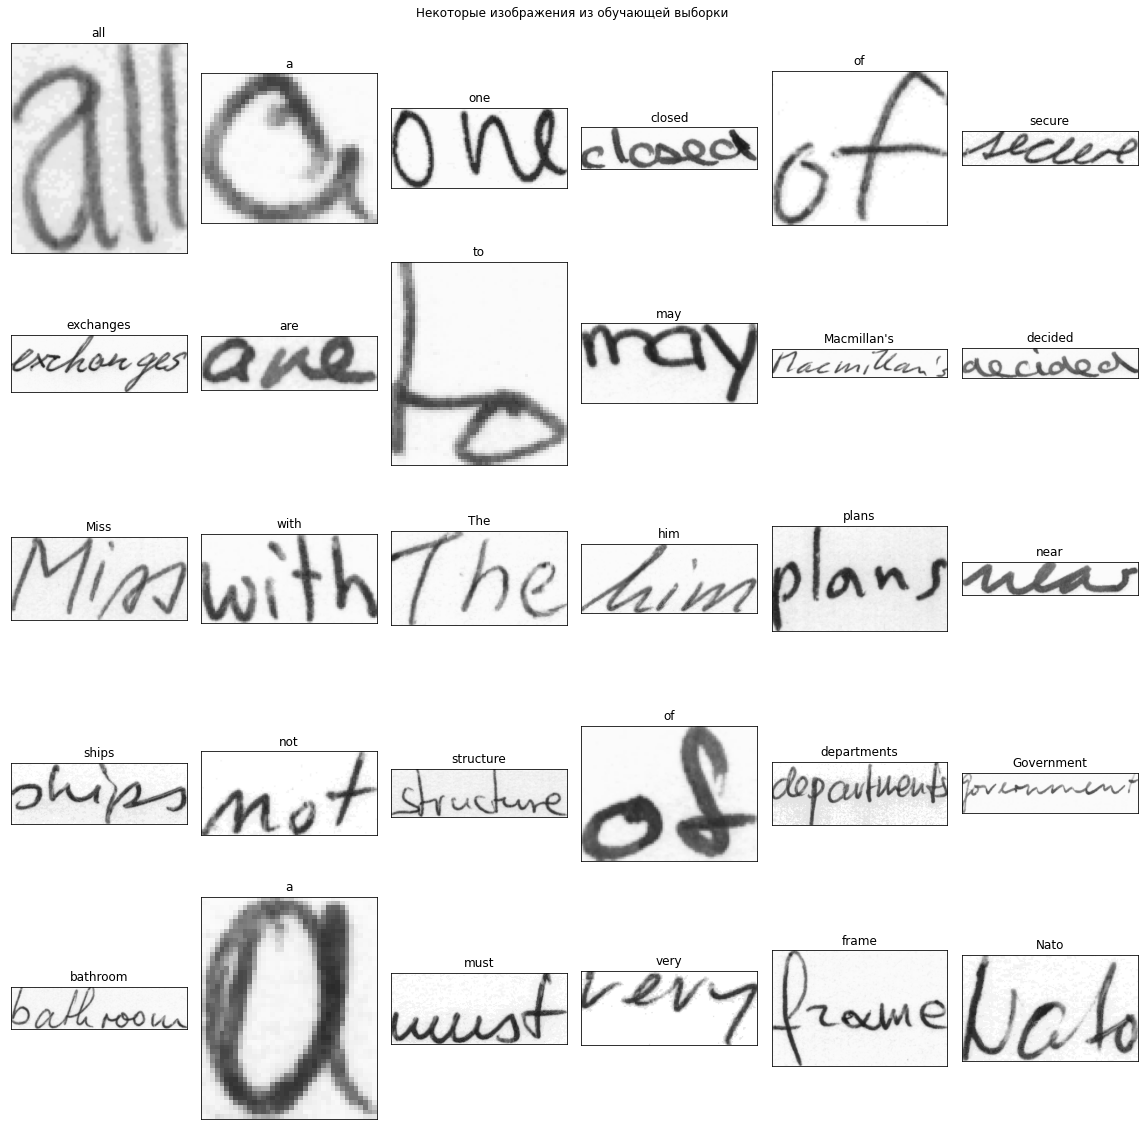

In [5]:
train_dir = '/DATA/data/rec/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

## Тестирование моделей

In [6]:
def get_dict(filename, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        img_path, label = l.split('\t')[:2]
        if not set(label).issubset(alphabet):
            continue
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [7]:
def general_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'LC + UC, short words',
             'MC, all words', 'MC, long words', 'MC, short words')
    if alphabet == alphabet.lower():
        cases = cases[3:]
        
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    short_num = 0
    all_num = 0
    long_char = 0
    short_char = 0
    all_char = 0

    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)
            
            suf = ', short words'
            if is_long:
                suf = ', long words'
            correct_num[case + suf] += is_correct
            edit_dis[case + suf] += cur_edit_dis
            norm_edit_dis[case + suf] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1
        else:
            short_char += len(target)
            short_num += 1
            
    case_function = lambda case, all_, short, long: max(all_ if (case[-9:-6] == 'all') else (long if (case[-10:-6] == 'long') else short), 1)
    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / case_function(case, all_num, short_num, long_num)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / case_function(case, all_num, short_num, long_num)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / case_function(case, all_char, short_char, long_char)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [8]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)
    lower_alphabet = ''.join(set(alphabet.lower()))

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in lower_alphabet}, 'ins': {char: 0 for char in lower_alphabet}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in lower_alphabet} for sym in lower_alphabet})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    if alphabet == alphabet.lower():
        cases = cases[2:]
    
    mistakes = []
    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)
        else:
            pred, target = pred.lower(), target.lower()
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

### Модель, обученная на словаре LC + UC + Num + Pc3

Получим предсказания обученной модели, а также правильные метки:

In [9]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_LC_UC_Num_Pc3.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [10]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8217966769923966
Accuracy (LC + UC, long words): 0.5612535612535613
Accuracy (LC + UC, short words): 0.8325221368674134
Accuracy (MC, all words): 0.8339059419881724
Accuracy (MC, long words): 0.5712250712250713
Accuracy (MC, short words): 0.8447194042104028
Normalized edit distance 1 (LC + UC, all words): 0.06386012299241943
Normalized edit distance 1 (LC + UC, long words): 0.0854118273191269
Normalized edit distance 1 (LC + UC, short words): 0.06297293033204601
Normalized edit distance 1 (MC, all words): 0.05875323458998067
Normalized edit distance 1 (MC, long words): 0.08298199812647719
Normalized edit distance 1 (MC, short words): 0.05775583870640467
Normalized edit distance 2 (LC + UC, all words): 0.07009180790960452
Normalized edit distance 2 (LC + UC, long words): 0.0874983772556147
Normalized edit distance 2 (LC + UC, short words): 0.06821895995418546
Normalized edit distance 2 (MC, all words): 0.06589235270379339
Normalized edit distance 2 (MC, 

In [11]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

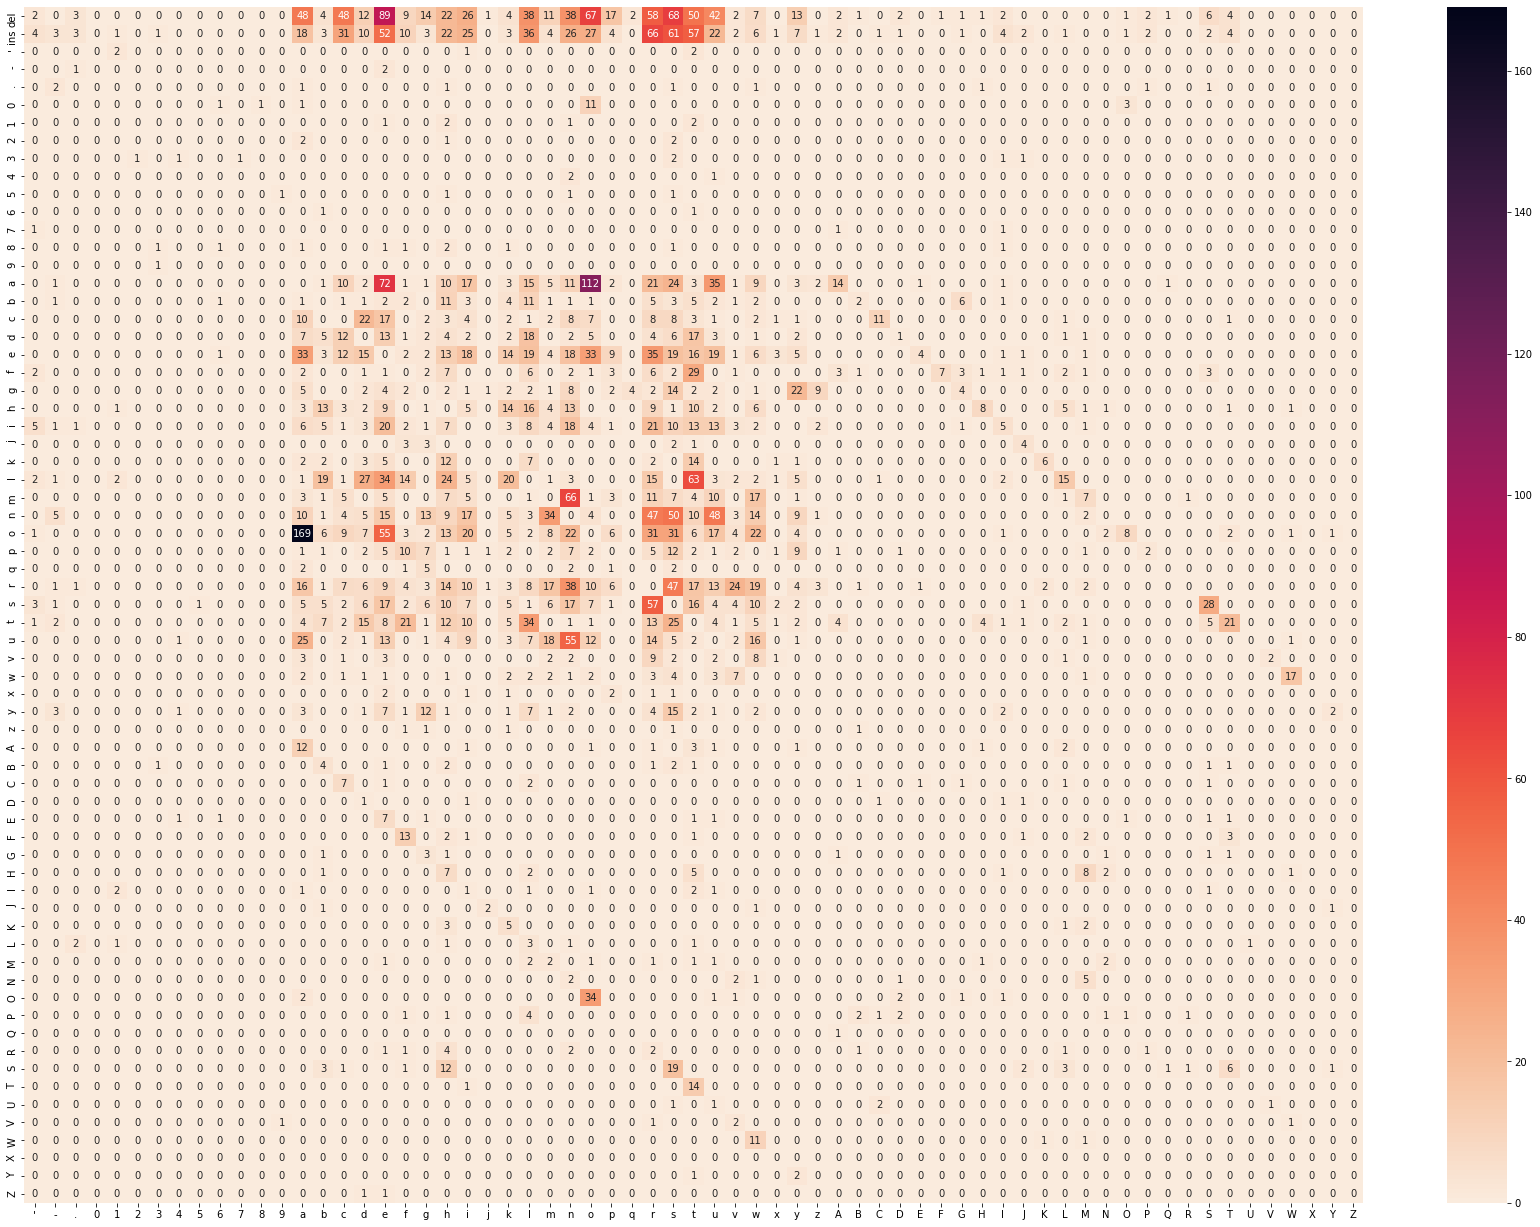

In [12]:
plt.figure(figsize=(30, 22))
sns.heatmap(tables['LC + UC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

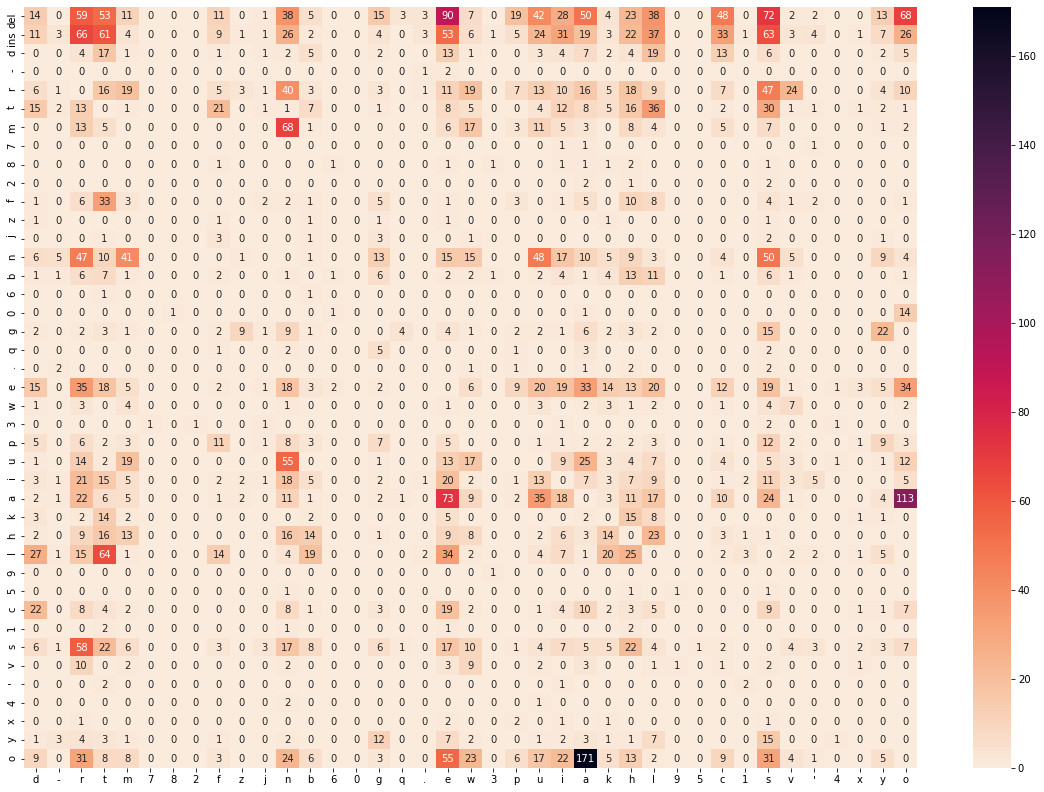

In [13]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

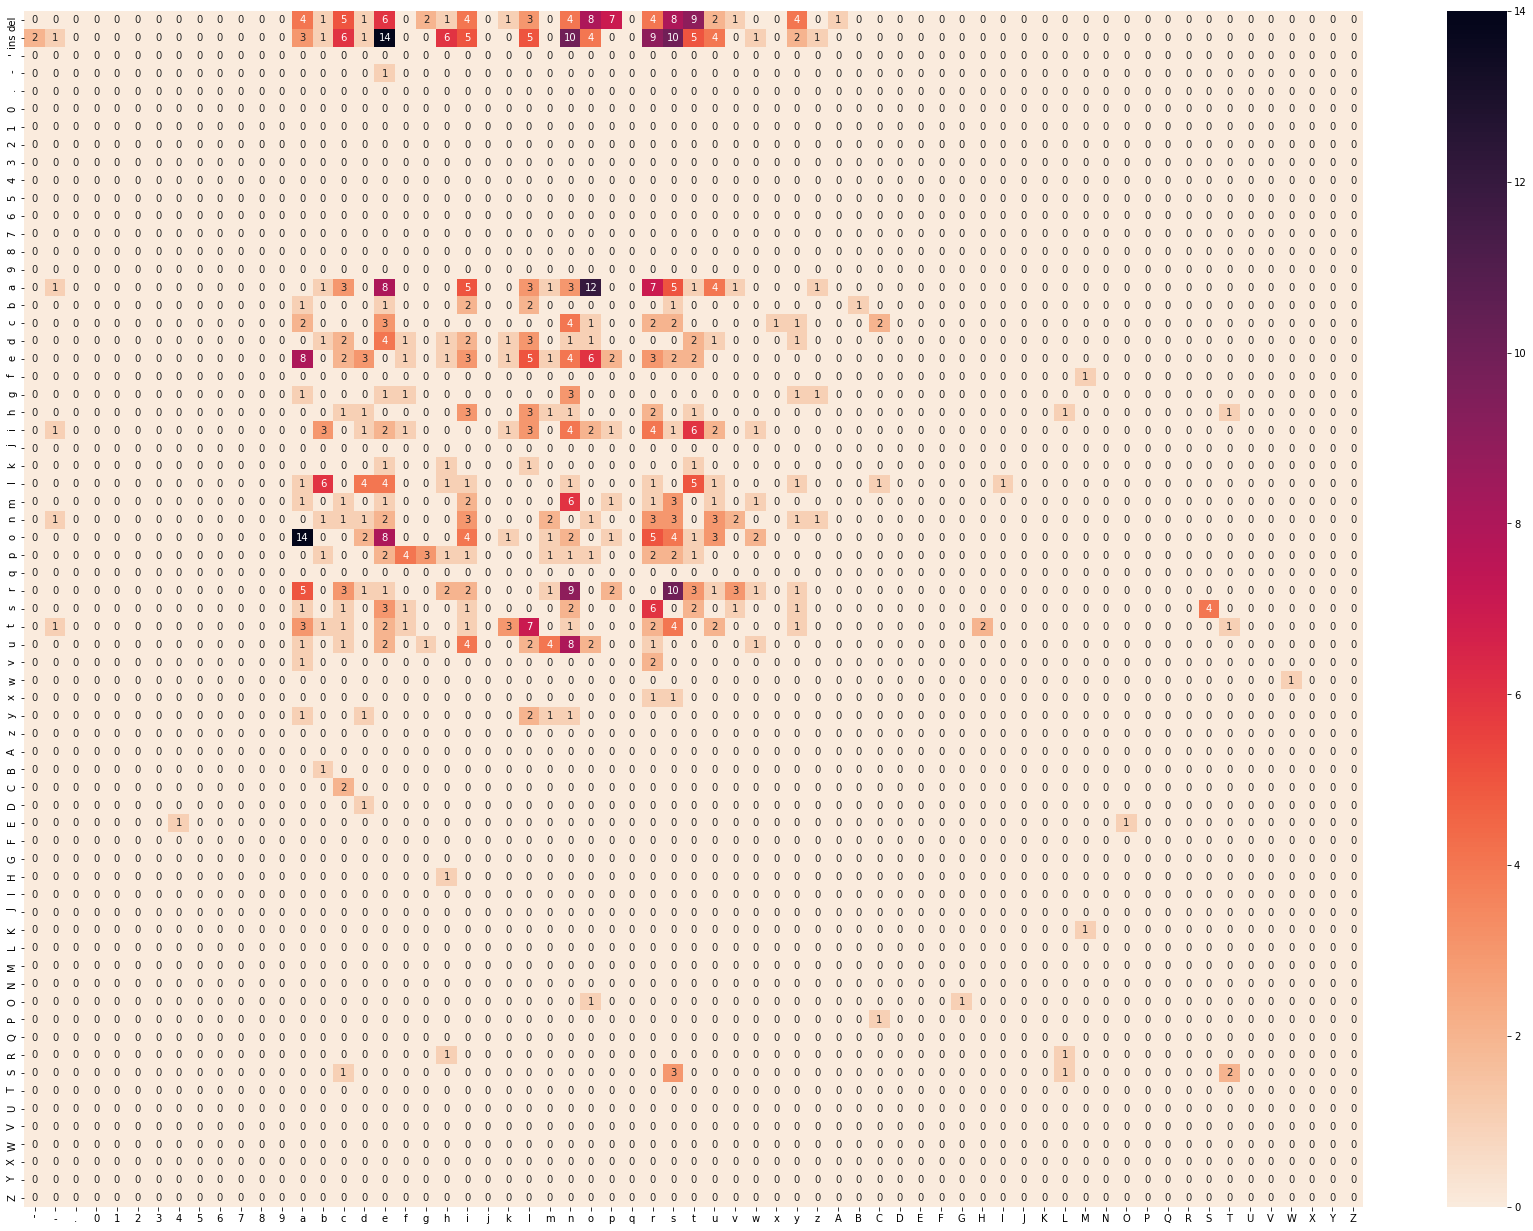

In [14]:
plt.figure(figsize=(30, 22))
sns.heatmap(tables['LC + UC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

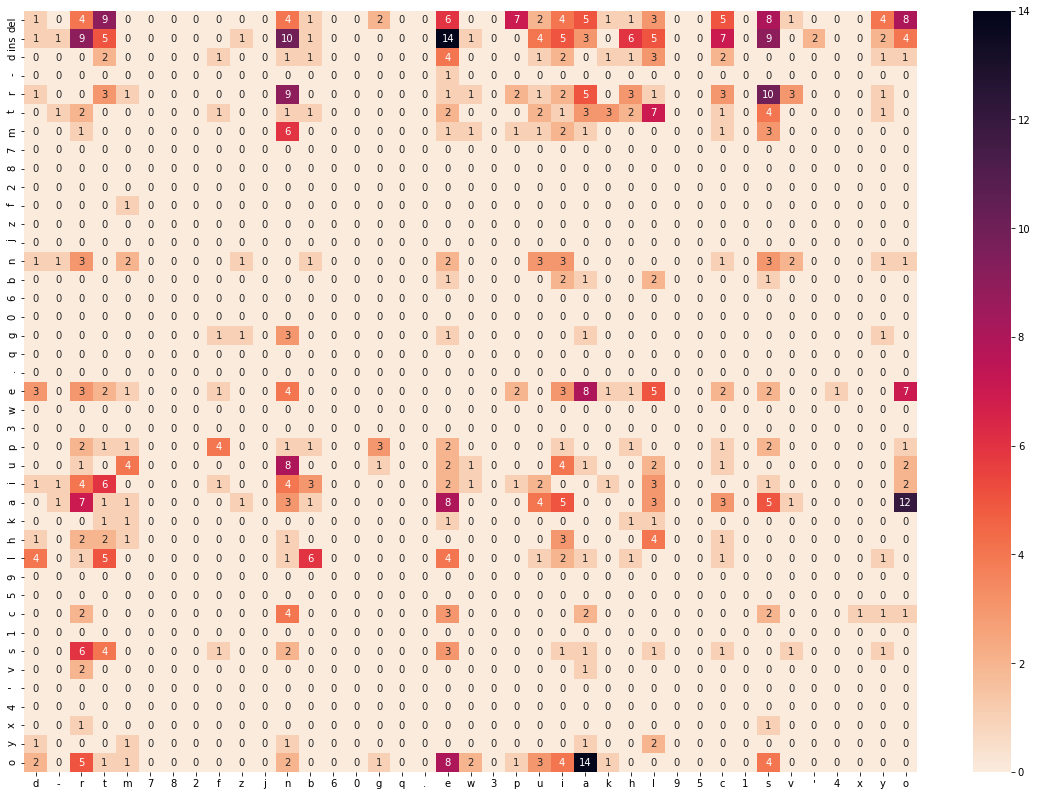

In [15]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

Посмотрим на некоторые неправильно распознанные изображения:

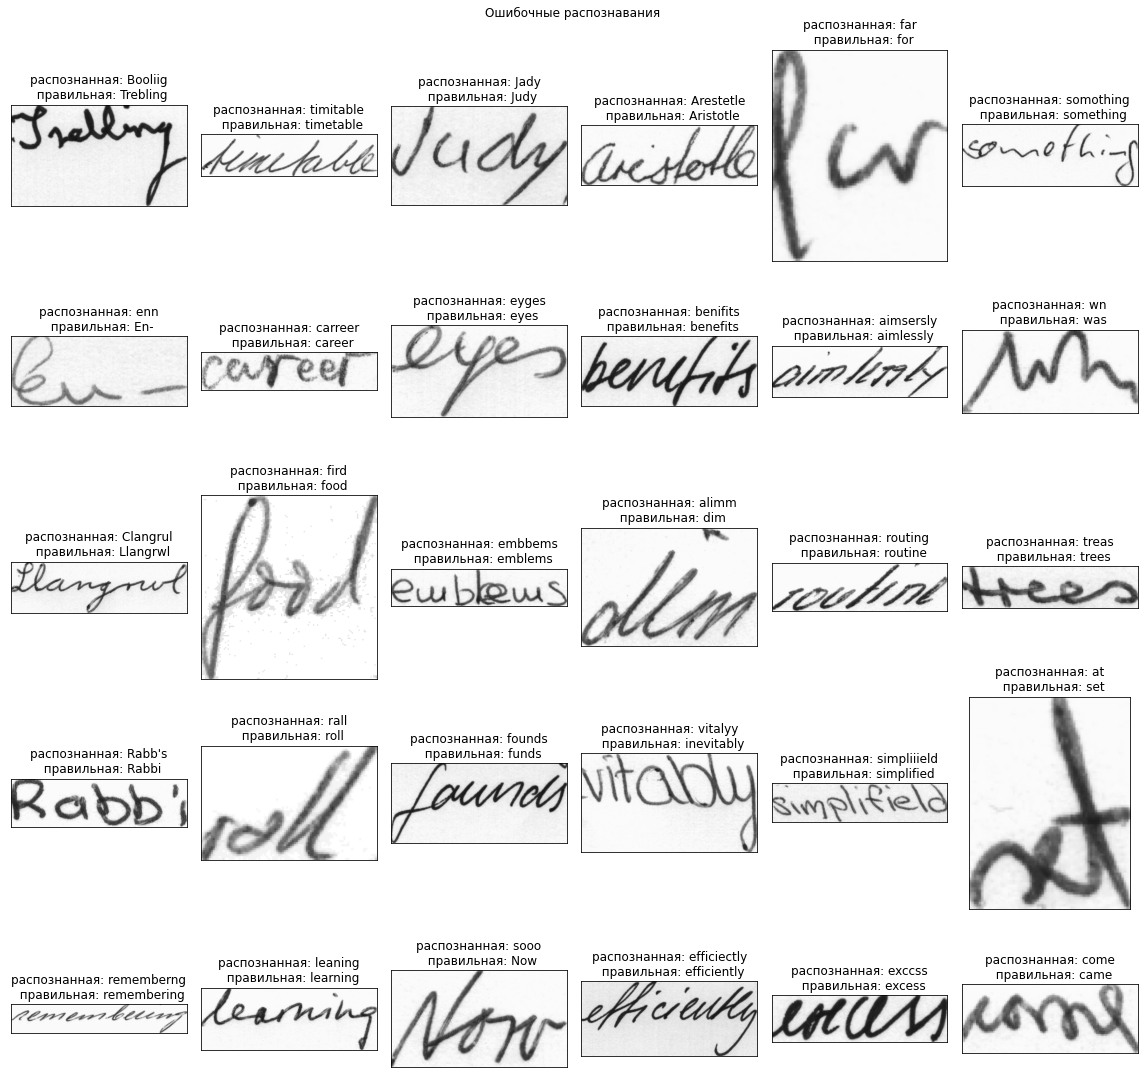

In [16]:
test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

Видно, что большая часть ошибок - пропущенные или лишние символы в слове. Объяснение этому даётся в статье про SRN: если на этапе нахождения визуального контекста модель неправильно определила количество символов, она уже не может исправить это на этапе учёта семантического контекста. Посчитаем долю таких ошибок:

In [17]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 33.25%


Видим, что на самом деле всего в трети случаев модель неправильно определяет количество символов. То есть большая часть приходится всё же на их неправильное распознавание. Компенсировать его можно за счёт семантического контекста, за который отвечает модуль GSRM. Тогда имеет смысл попробовать увеличить коэффицент при gsrm_loss в вычислении итогового лосса.

### Модель, обученная на словаре MC

Получим предсказания обученной модели, а также правильные метки:

In [18]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_MC.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [19]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.8559576691925791
Accuracy (MC, long words): 0.6571936056838366
Accuracy (MC, short words): 0.8635469650729061
Normalized edit distance 1 (MC, all words): 0.051006766311672225
Normalized edit distance 1 (MC, long words): 0.07080491296743523
Normalized edit distance 1 (MC, short words): 0.0502508248693396
Normalized edit distance 2 (MC, all words): 0.05710642966213512
Normalized edit distance 2 (MC, long words): 0.07037643207855974
Normalized edit distance 2 (MC, short words): 0.05578468610925452


In [20]:
tables, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Посмотрим на посимвольные таблицы ошибок для разных длин слов:

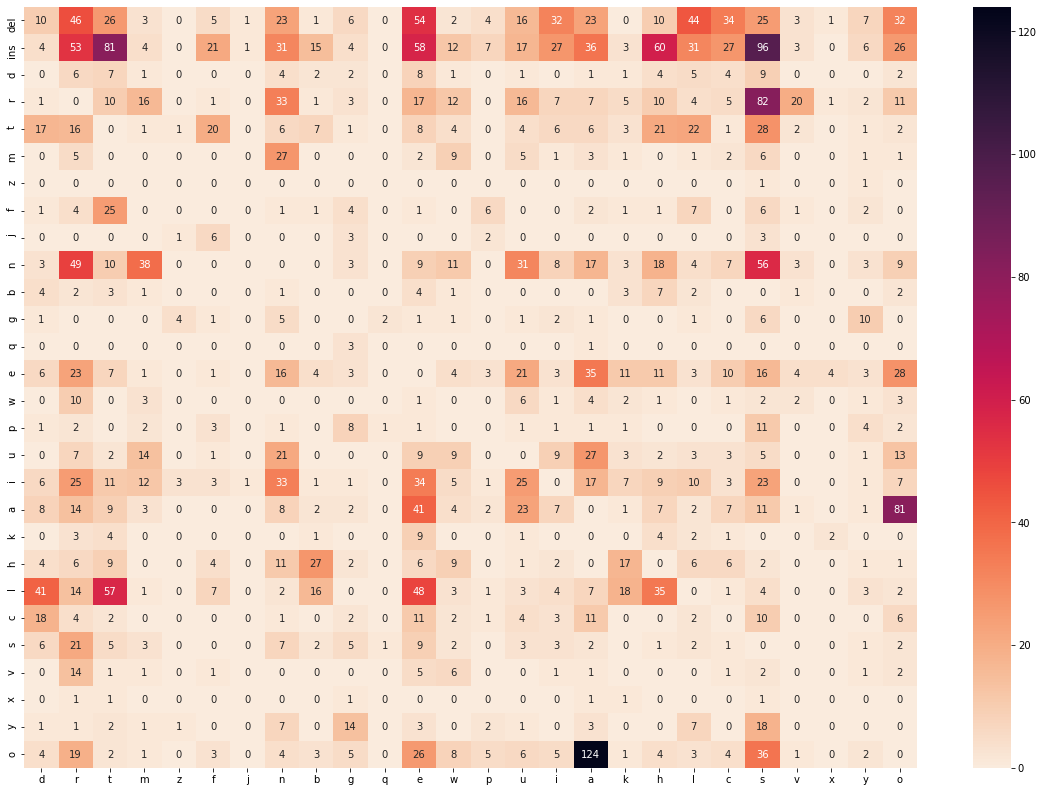

In [21]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

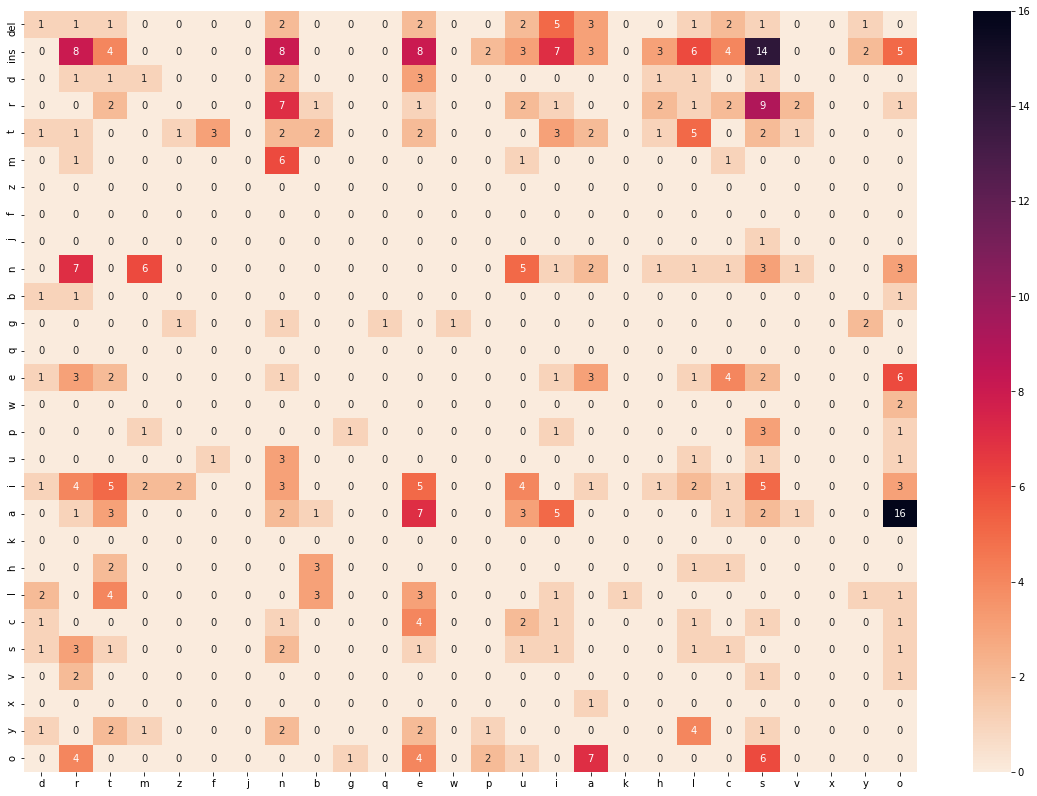

In [22]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

Посмотрим на некоторые неправильно распознанные изображения:

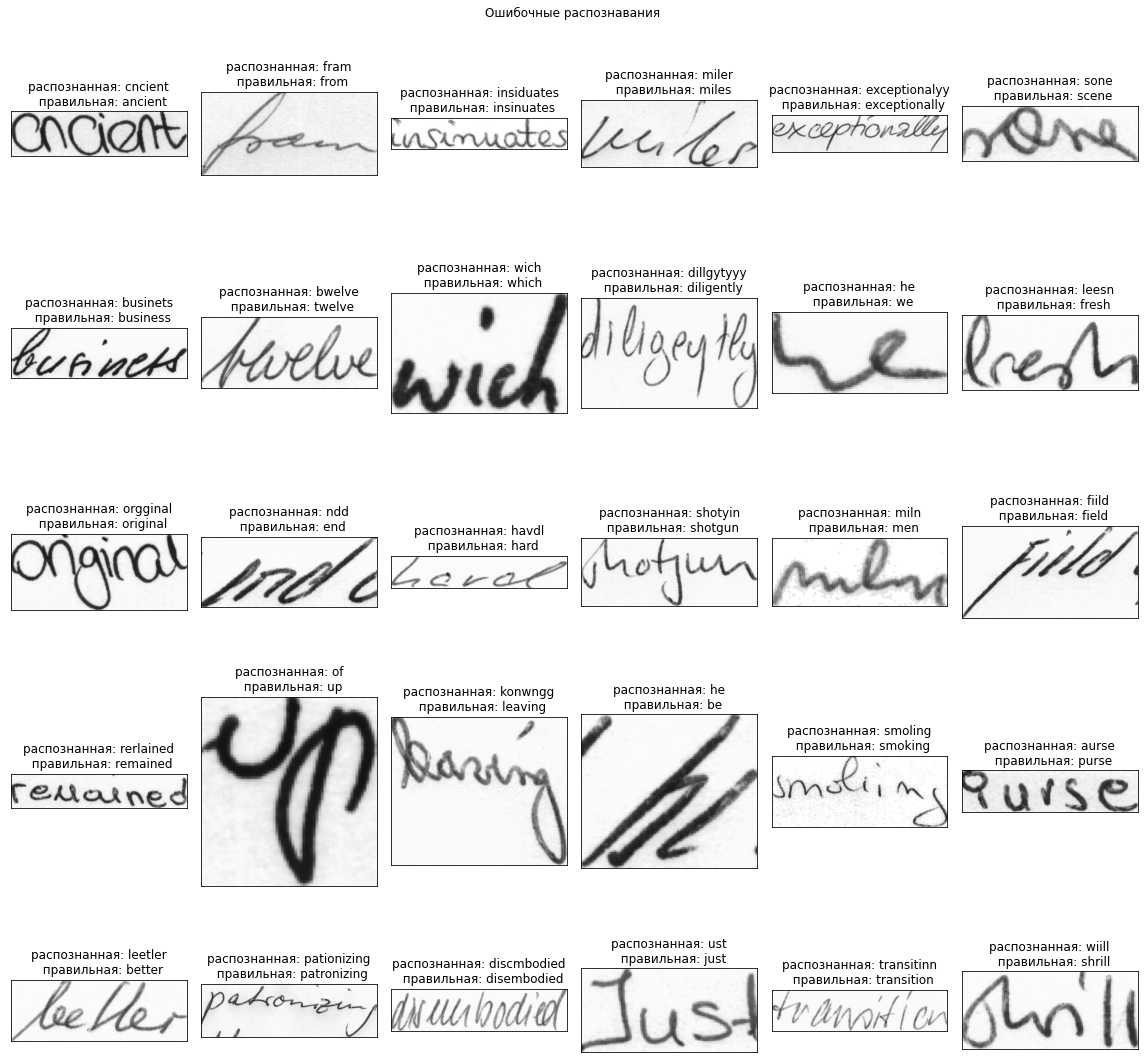

In [23]:
test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [24]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 38.41%


### Модель, предобученная на MJSynth + SynthText (словарь LC + UC + Num + Pc3):

Получим предсказания обученной модели, а также правильные метки:

In [25]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_MJSST+original_LC_UC_Num_Pc3.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [26]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8789073500422416
Accuracy (LC + UC, long words): 0.7635327635327636
Accuracy (LC + UC, short words): 0.8836568345745617
Accuracy (MC, all words): 0.8924246691072937
Accuracy (MC, long words): 0.7735042735042735
Accuracy (MC, short words): 0.897320119627045
Normalized edit distance 1 (LC + UC, all words): 0.042587664128827286
Normalized edit distance 1 (LC + UC, long words): 0.04491013264282696
Normalized edit distance 1 (LC + UC, short words): 0.042492057907234086
Normalized edit distance 1 (MC, all words): 0.03724185799028667
Normalized edit distance 1 (MC, long words): 0.04259573289252977
Normalized edit distance 1 (MC, short words): 0.03702146156846204
Normalized edit distance 2 (LC + UC, all words): 0.044832021791767554
Normalized edit distance 2 (LC + UC, long words): 0.04595612099182137
Normalized edit distance 2 (LC + UC, short words): 0.04471107510510804
Normalized edit distance 2 (MC, all words): 0.04025423728813559
Normalized edit distance 2 (

Посмотрим на некоторые неправильно распознанные изображения:

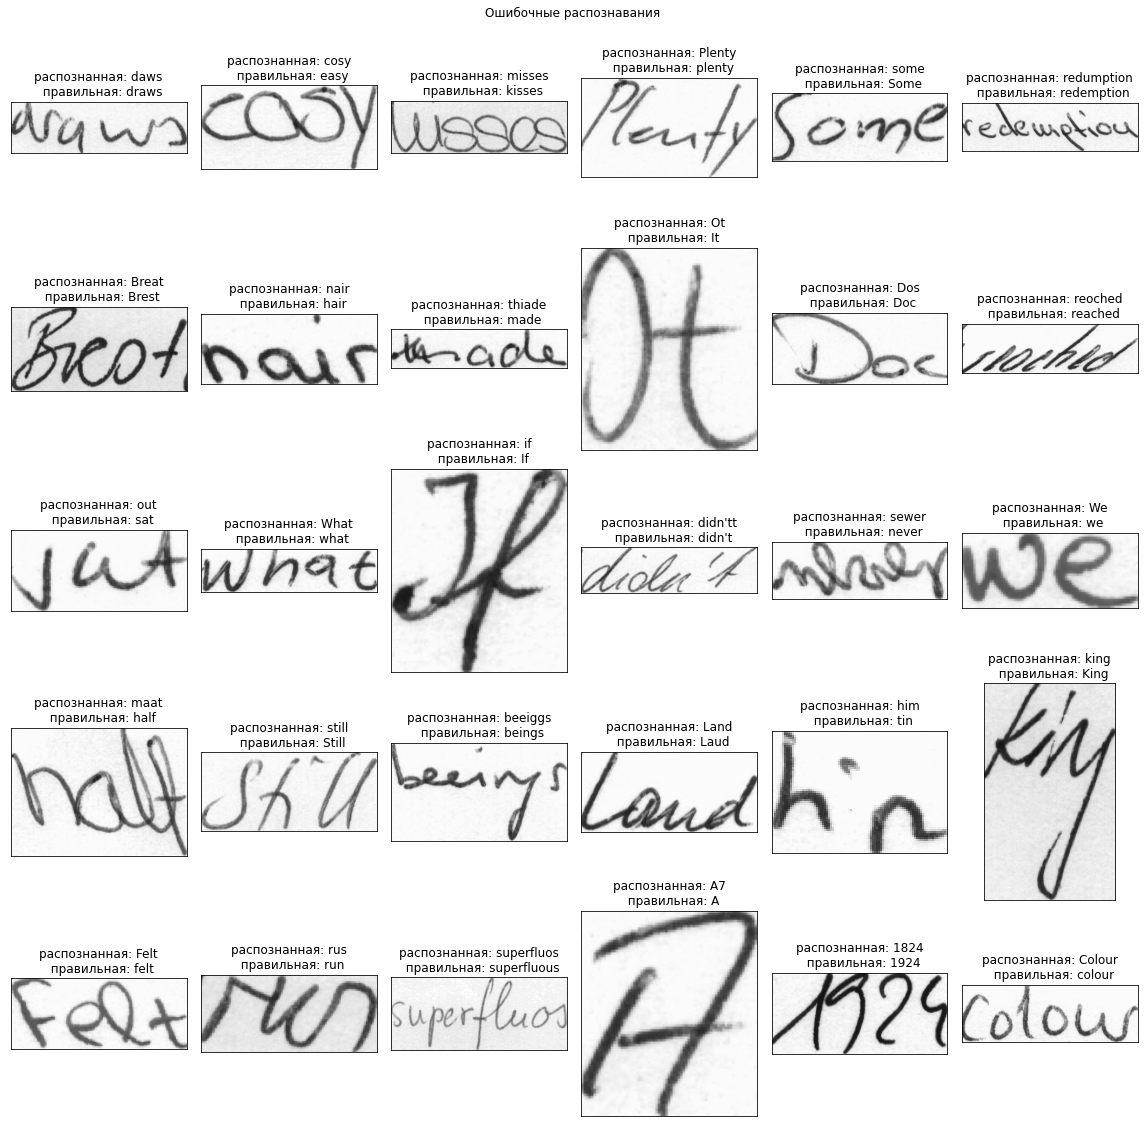

In [27]:
_, mistakes = detailed_stat(pred_file, target_file)

test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [28]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 31.95%


### Модель, предобученная на MJSynth + SynthText (словарь MC):

Получим предсказания обученной модели, а также правильные метки:

In [29]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_MJSST+original_MC.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [30]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.9044290567023778
Accuracy (MC, long words): 0.8170515097690941
Accuracy (MC, short words): 0.9077653441844693
Normalized edit distance 1 (MC, all words): 0.03313914332336067
Normalized edit distance 1 (MC, long words): 0.03272850595230703
Normalized edit distance 1 (MC, short words): 0.03315482245797601
Normalized edit distance 2 (MC, all words): 0.03583235734511438
Normalized edit distance 2 (MC, long words): 0.03273322422258593
Normalized edit distance 2 (MC, short words): 0.036141042987789966


Посмотрим на некоторые неправильно распознанные изображения:

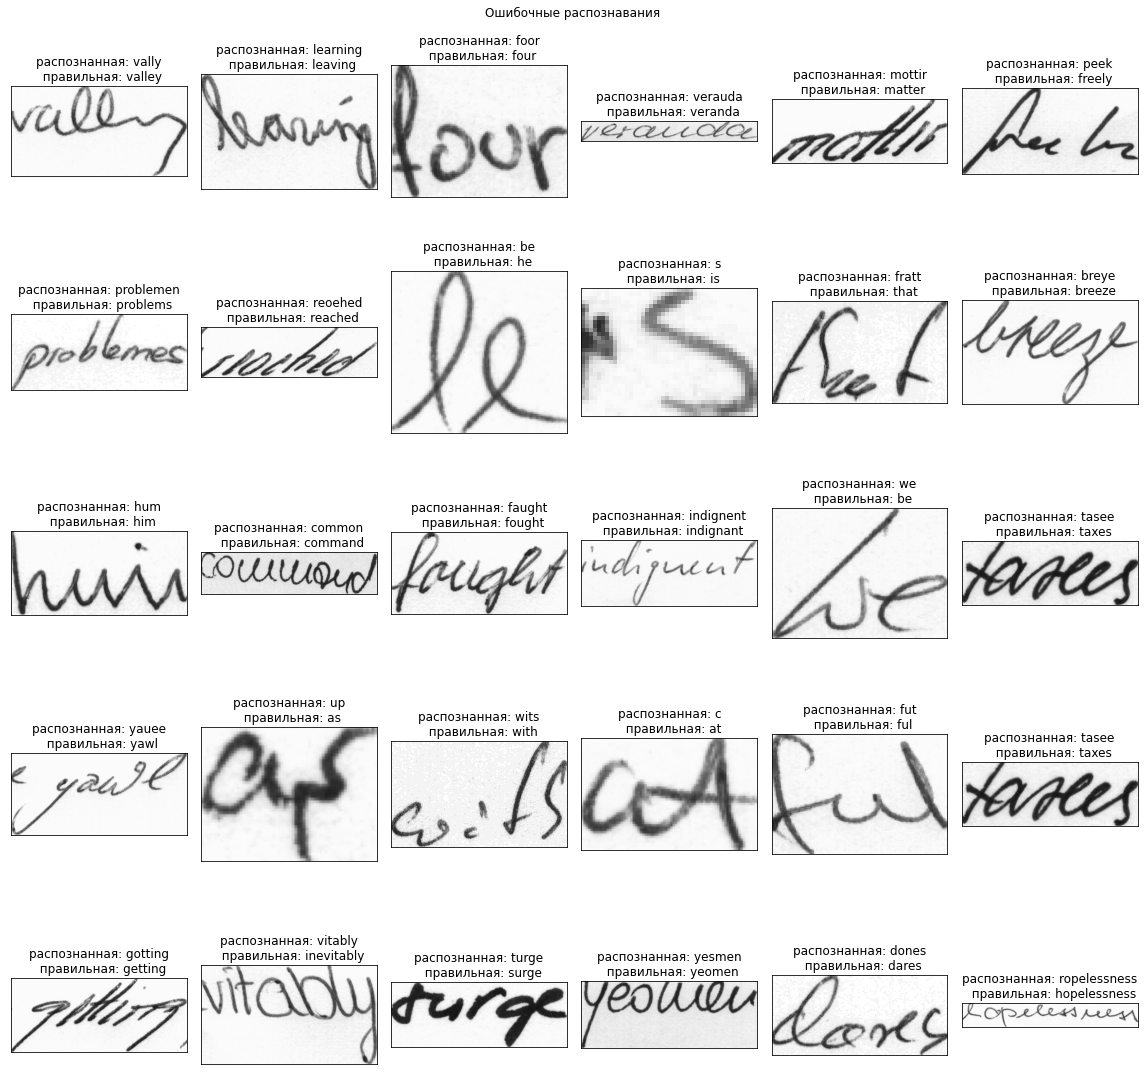

In [31]:
_, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [32]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 37.39%


### Модель, предобученная на MJSynth + SynthText (словарь MC + Num):

Получим предсказания обученной модели, а также правильные метки:

In [33]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_MJSST+original_MC_Num.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [34]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz0123456789")

Accuracy (MC, all words): 0.884375
Accuracy (MC, long words): 0.7464539007092199
Accuracy (MC, short words): 0.8896323330629899
Normalized edit distance 1 (MC, all words): 0.04014986794527806
Normalized edit distance 1 (MC, long words): 0.04483702615351553
Normalized edit distance 1 (MC, short words): 0.03997120092517493
Normalized edit distance 2 (MC, all words): 0.04368652148844636
Normalized edit distance 2 (MC, long words): 0.044444444444444446
Normalized edit distance 2 (MC, short words): 0.043611124656621314


Посмотрим на некоторые неправильно распознанные изображения:

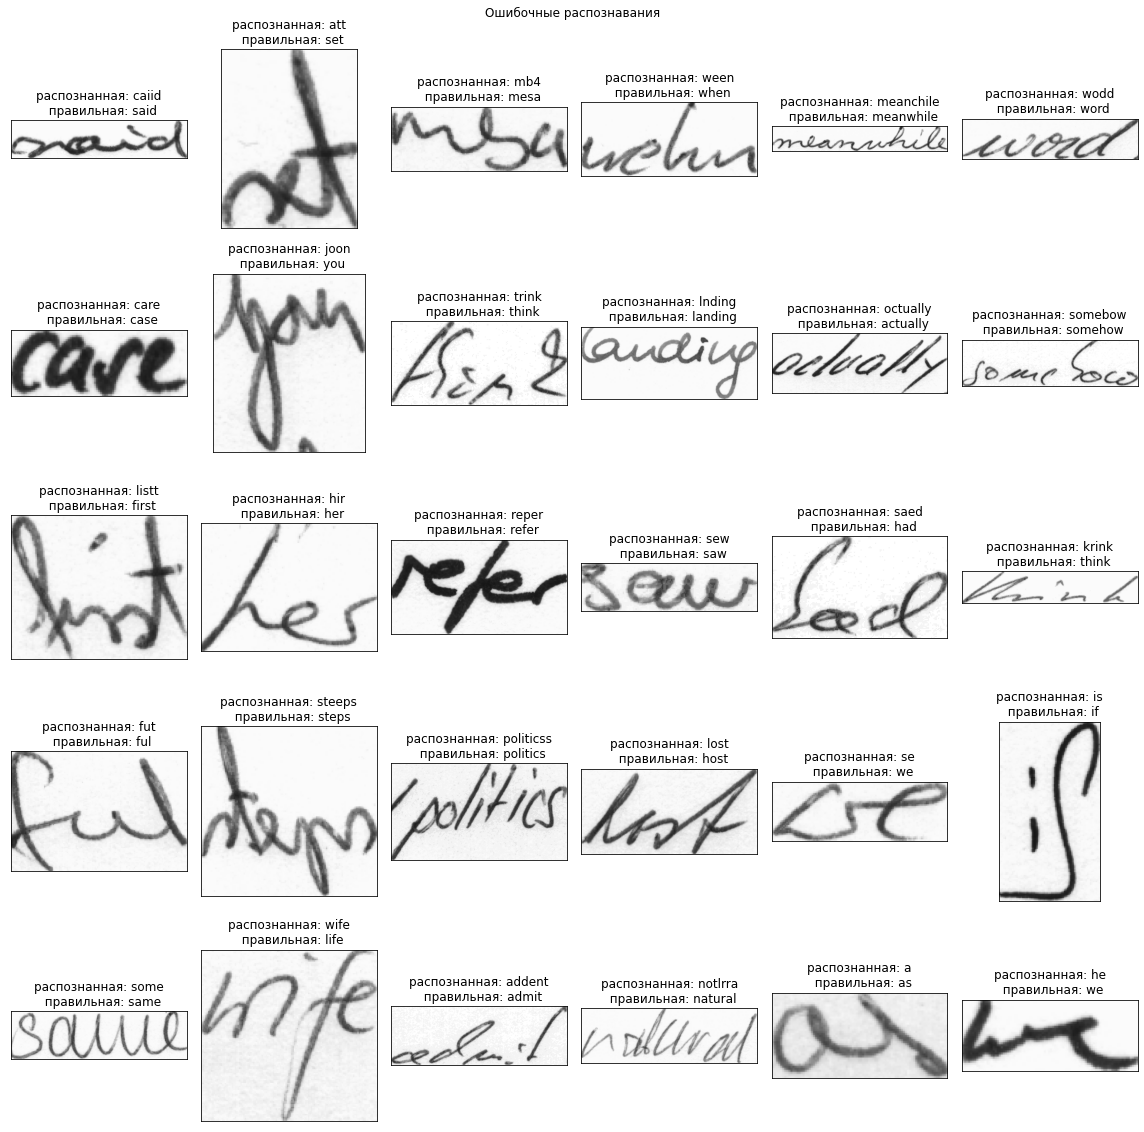

In [35]:
_, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz0123456789")

test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [36]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 38.57%


### Предобученная модель из репозитория (словарь MC + Num):

Получим предсказания обученной модели, а также правильные метки:

In [37]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_pretrained_original_MC_Num.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [38]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz0123456789")

Accuracy (MC, all words): 0.9076171875
Accuracy (MC, long words): 0.8156028368794326
Accuracy (MC, short words): 0.911124628277913
Normalized edit distance 1 (MC, all words): 0.03373911561167415
Normalized edit distance 1 (MC, long words): 0.03460591565644757
Normalized edit distance 1 (MC, short words): 0.03370607457184904
Normalized edit distance 2 (MC, all words): 0.036146715749323634
Normalized edit distance 2 (MC, long words): 0.03431372549019608
Normalized edit distance 2 (MC, short words): 0.03632905837031258


Посмотрим на некоторые неправильно распознанные изображения:

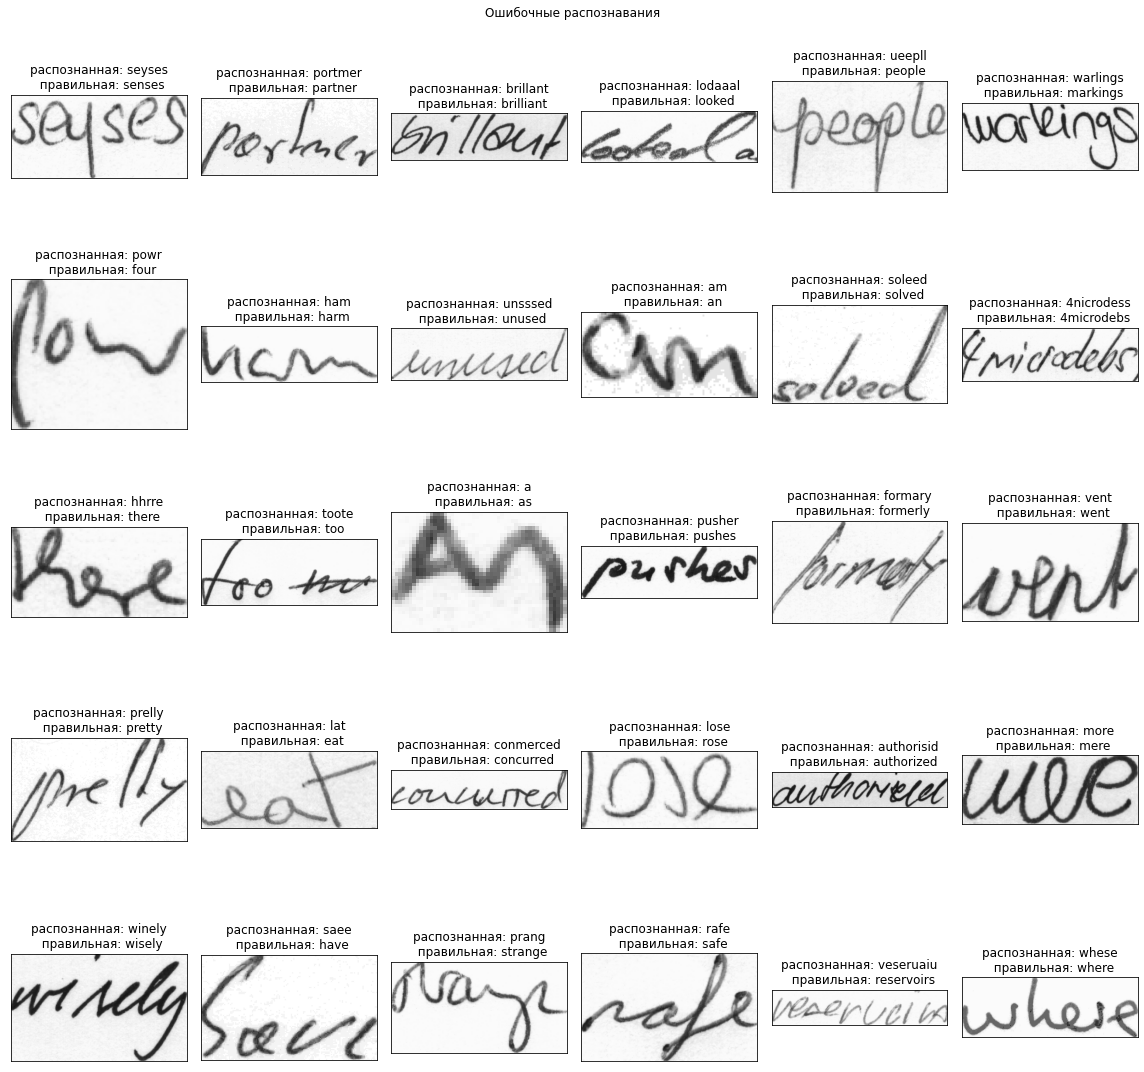

In [39]:
_, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz0123456789")

test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [40]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 37.98%


### Модель с входным изображением 32 на 100 (словарь LC + UC + Num + Pc3)

Получим предсказания обученной модели, а также правильные метки:

In [41]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn32_original_LC_UC_Num_Pc3.txt'
target_file = '/DATA/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [42]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8411715009856379
Accuracy (LC + UC, long words): 0.6011396011396012
Accuracy (LC + UC, short words): 0.8510526007154167
Accuracy (MC, all words): 0.8522106448887637
Accuracy (MC, long words): 0.6096866096866097
Accuracy (MC, short words): 0.8621943353075705
Normalized edit distance 1 (LC + UC, all words): 0.055130057254865424
Normalized edit distance 1 (LC + UC, long words): 0.08461035348637572
Normalized edit distance 1 (LC + UC, short words): 0.05391647794597421
Normalized edit distance 1 (MC, all words): 0.0504853793632148
Normalized edit distance 1 (MC, long words): 0.0828987104285788
Normalized edit distance 1 (MC, short words): 0.0491510593955911
Normalized edit distance 2 (LC + UC, all words): 0.06161723163841808
Normalized edit distance 2 (LC + UC, long words): 0.08710891860314163
Normalized edit distance 2 (LC + UC, short words): 0.05887447096783205
Normalized edit distance 2 (MC, all words): 0.05780871670702179
Normalized edit distance 2 (MC, 

In [43]:
_, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на некоторые неправильно распознанные изображения:

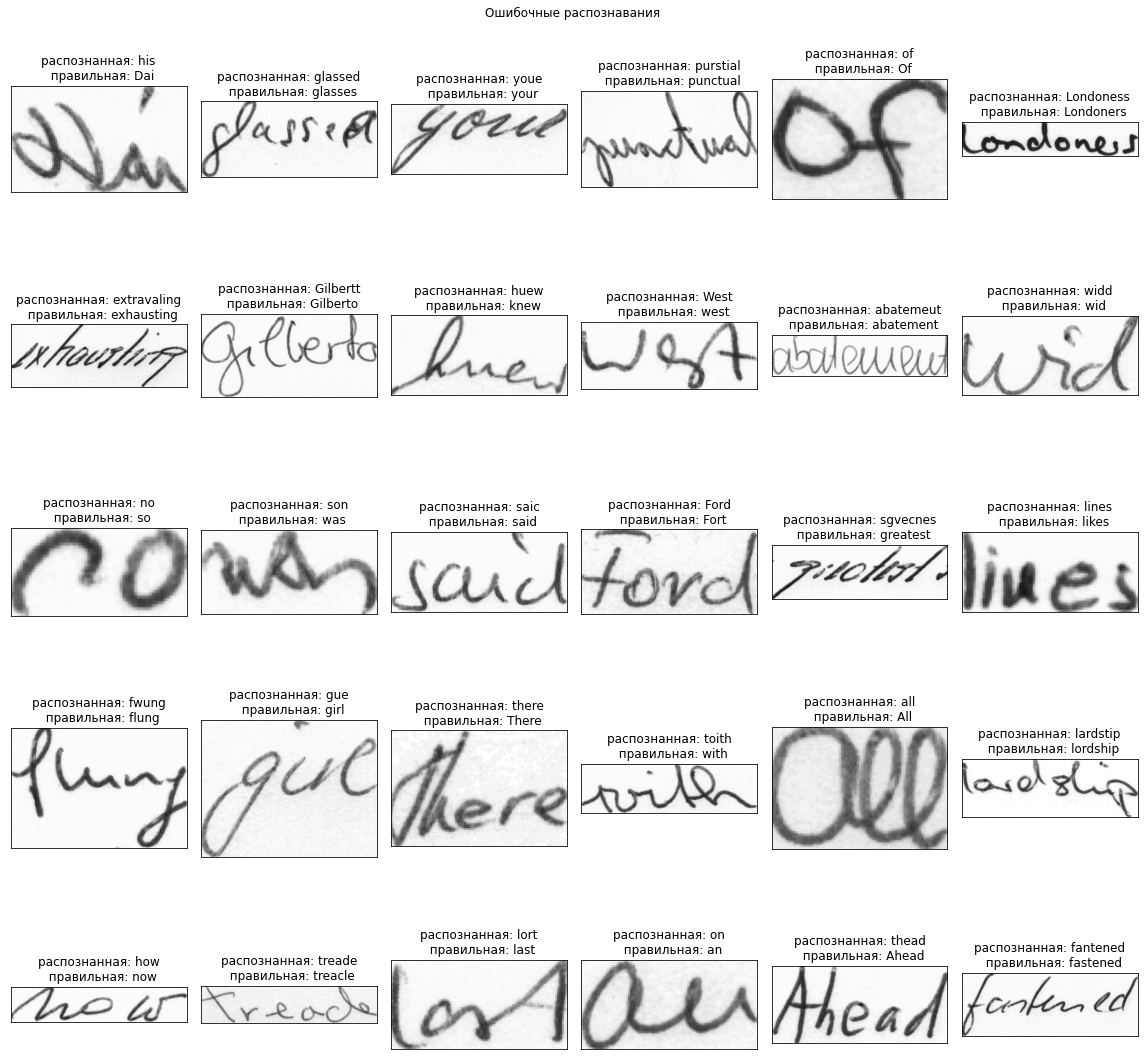

In [44]:
test_dir = '/DATA/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [45]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 33.09%


**Вывод:** Качество модели сильно не упало, то есть оно слабо зависит от размера входной картинки.